<img 
    style="position: absolute; 
           left: 60%; 
           top: 0; /* Added to ensure proper positioning */
           height: 900px; 
           width: 40%; /* Maintain the original width */
           object-fit: cover; /* Adjust if necessary */
           clip-path: inset(0px 50px 0px 50px round 10px);" 
    src="https://www.mathworks.com/help/examples/stats/win64/ParellelBayeianOptimizationExample_01.png" 
/>

</figure>


<h1 style="width: 60%; color: #EC6842		; font-size: 40pt;">
    <Strong>
        CEGM2003 project: Bayesian optimization for truss structures
    </Strong>
</h1>

<h2 id="Background"><B>
    Background<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>
<p style="text-align: justify; width: 60%; font-weight: normal;">
     Structures that make optimal use of the material they are made of reduces the cost and environmental impact of their construction as the amount of material required. Optimization of structural design is a challenging task because of the high number of design parameters and the relatively expensive evaluation of the suitability of any given design. Standard optimization techniques in high-dimensional design space require a very large number of possible designs that need to be evaluated. In structural analysis, where evaluating the objective function and checking the constraints involves the solution of a structural mechanics problem, e.g. with finite elements, this quickly becomes very expensive, even if the model is relatively simple from structural point of view. Bayesian optimization is a machine-learning-based optimization technique that aims to reduce the number of evaluations of the objective function through data-driven exploration of the design space with a probabilistic surrogate.
</p>

<h2 id="Background"><B>
    Objective & Description<a class="anchor-link" href="#Background">&#182;</a>
    </B>
</h2>

<div style="width: 60%; border-top: 4px solid #00B8C8; border-left: 4px solid #00B8C8; background-color: #FFFFFF; padding: 1em 1em 1em 1em; color: #24292E; margin: 10px 0 20px 0; box-sizing: border-box;">
    <div style="background-color: #00B8C8; color: white; padding: 0.2em 1em; margin: -1em -1em 0em -1em; font-size: 1.2em;"><strong>Project Objective</strong></div>
    <p><strong>The aim of this project is to find the optimal truss design,</strong><br><br>
    we will achieve this through finding the optimal set of nodal coordinates and cross-sectional properties. This project's primary objective is to minimize as much as possible the total weight of the structure, while satisfying some natural constraints of the structure. Moreover, this project will also aim to explore the efficiency of current methods and potentially develop a proprietary solver.</p>
</div>

## <strong> X | Imports</strong>

In [ ]:
import sys
import io
import os
import pickle
import numpy as np
import pandas as pd
import torch

from botorch.utils.transforms import normalize
from botorch.utils.transforms import unnormalize
from tabulate import tabulate
from contextlib import redirect_stdout
from sklearn.preprocessing import MinMaxScaler

from botorch.models import SingleTaskGP
from botorch.models import SaasFullyBayesianSingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.fit import fit_fully_bayesian_model_nuts
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import GaussianLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from dash import Dash
from dash import dcc, html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.graph_objects as go

sys.path.append('../pyJive/')
from utils import proputils as pu
from names import GlobNames as gn
import main

from dash import Dash, dcc, html, Input, Output
import plotly.graph_objects as go
from TRUSS_convergence import plot_truss_layout, get_truss_data_for_iteration, loss_function_figure
from TRUSS_convergence import layout

In [189]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## <strong> 0 | Classes & Dependencies</strong>

In [19]:
class TRUSS():
    def __init__(self, file_path, file_name, output_path, write_name, violation_penalty, scalers, bounds, lower_area=4e-3, freq_constraints=[20, 40, 60], mass_weight=1, freq_weight=1):
        # Configuration Parameters
        self.config = {
            "read_file_path": file_path,
            "read_file_name": file_name,
            "write_file_path": output_path,
            "write_file_name": write_name,
            "violation_penalty": violation_penalty,
            "scalers": {"y": scalers[0], "a": scalers[1]},
            "lower_area": lower_area,
            "bounds" : bounds,
            "freq_constraints": freq_constraints,
            "mass_weight": mass_weight,
            "freq_weight": freq_weight,
            "density": 7850,  # kg/m^3 As per Garnachos
        }

        self.state = {
            "nodes": {},
            "connectivity": None,
            "member_df": None,
            "y_coordinates": None,
            "x_coordinates": None,
            "cross_sections": None,
            "lengths": None,
            "mass_norm": 360,
            "monitor_df": None
        }

        self.columns = ["Metric", "Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"]
        self.state["monitor_df"] = pd.DataFrame(columns=self.columns)
    # -------------------------- Import & Writing Files -------------------------- #
    def read_geom_file(self):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], self.config["read_file_name"]))
        with open(path, 'r') as file:
            lines = file.readlines()

        nodes = {}
        members = []
        section = None

        for line in lines:
            line = line.strip()
            if line.startswith('node:'):
                section = 'node'
            elif line.startswith('member:'):
                section = 'member'
            else:
                if section == 'node' and line:
                    parts = line.split()
                    node_number = int(parts[0])
                    node_data = tuple(map(float, parts[1:]))
                    nodes[node_number] = node_data
                elif section == 'member' and line:
                    member_data = tuple(map(int, line.split()))
                    members.append(member_data)

        self.state["nodes"] = nodes
        self.state["member_df"] = pd.DataFrame(members, columns=['Node #1', 'Node #2', 'Number of Elements', 'Cross-section Type'])

        connectivity = self.state["member_df"].to_numpy()
        self.state["connectivity"] = connectivity[:, :2]
        self.state["y_coordinates"] = np.array([value[1] for _, value in nodes.items()])
        self.state["x_coordinates"] = np.array([value[0] for _, value in nodes.items()])

    def write_geom_file(self,path_,write_file): 
        path = os.path.normpath(os.path.join(path_,write_file))
        file = open(path)

        for i, (x, _) in self.state["nodes"].items():
            self.state["nodes"][i] = (x, self.state["y_coordinates"][i])

        geom = 'node: node #, x-coordinate; y-coordinate\n'
        for node_num, coords in self.state["nodes"].items():
            geom += f"{node_num} {' '.join(map(str, coords))}\n"
        
        connectivity = self.state["member_df"].to_numpy()
        geom += '\nmember: Node #1; Node #2; number of elements; cross-section type\n'
        for row in connectivity:
            geom += ' '.join(map(str, row)) + '\n'

        output_file_path = os.path.normpath(os.path.join(path_,'TRUSS.geom'))
        with open(output_file_path, 'w') as file:
            file.write(geom)
            
        return file.name
    
    def fit_scalers(self, initial_data):
        y_data = initial_data[:5].reshape(1, -1).T
        a_data = initial_data[5:].reshape(1, -1).T
        self.config["scalers"]["y"].fit(y_data)
        self.config["scalers"]["a"].fit(a_data)

    def scaler(self, mode, x_values, scaler_type):
        scaler = self.config["scalers"][scaler_type]
        x_values = x_values.reshape(1, -1).T
        if mode == 'scale':
            scaled_values = scaler.transform(x_values)
        elif mode == 'descale':
            scaled_values = scaler.inverse_transform(x_values)
        return scaled_values.flatten()
    
    def areas_coordinates_write_split(self, x_list):        
        y_coordinates = np.copy(self.state["y_coordinates"])  # Use a copy to avoid modifying the original array directly
        areas = x_list[5:]
        y_coords = x_list[:5]
        for i, y in enumerate(y_coords, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        self.state["y_coordinates"] = y_coordinates  # Update state

        return areas, y_coords
    # ---------------------------------------------------------------------------- #
    #                                TARGET FUNCTION                               #
    # ---------------------------------------------------------------------------- #
    def loss_function(self, x_list):
        """
        Calculate the loss for a given set of design parameters.
        Parameters:
        x_list (list): A list of design parameters.
        Returns:
        float: The calculated loss based on mass, frequency constraints, and imaginary penalties.
        """
        if isinstance(x_list,torch.Tensor):
            x_list = x_list.detach().cpu().numpy().flatten()
            self.temporary = x_list
        
        A_list, y_list = self.areas_coordinates_write_split(x_list)
        mass_truss = self.mass_truss(A_list, y_list)
        freq1, freq2, freq3 = self.eigenfrequencies(A_list)
        frequencies = np.array([freq1, freq2, freq3])

        freq_penalty = 0
        all_positive = True
        for f, t in zip(frequencies, self.config["freq_constraints"]):
            diff = f - t
            penalty_factor = 1 if diff >= 0 else self.config["violation_penalty"]
            freq_penalty += penalty_factor * (np.abs(diff) / t)
            if diff < 0:
                all_positive = False
        
        if all_positive:
            self.state["mass_norm"] = min(mass_truss, self.state["mass_norm"])

        normalized_mass_penalty = (mass_truss - self.state["mass_norm"]) / self.state["mass_norm"]
        normalized_freq_penalty = freq_penalty / len(self.config["freq_constraints"])
        constraint_violation = normalized_freq_penalty + normalized_mass_penalty

        LOSS = (self.config["mass_weight"] * normalized_mass_penalty +
                self.config["freq_weight"] * normalized_freq_penalty)
        # -------------------------- Optimisation monitoring ------------------------- #
        optmonitor_data = [
            ["Metric","Total Loss", "Natural Frequencies", "Mass of Truss", "Normalized Mass Loss", "Frequency Penalty", "Constraint Violation (Loss No W)"],
            ["Value",LOSS, frequencies, mass_truss, normalized_mass_penalty, normalized_freq_penalty, constraint_violation]
        ]
        print(f'{tabulate(optmonitor_data, headers="firstrow", tablefmt="grid")}\n')
        
        row_data = optmonitor_data[1][0:]
        new_data = pd.DataFrame([row_data], columns=self.columns)
        self.state["monitor_df"] = pd.concat([self.state["monitor_df"], new_data], ignore_index=True)
         
        return LOSS

    # ----------------------------- SUPPORT FUNCTIONS ---------------------------- #
    def eigenfrequencies(self,A_list):
        path = os.path.normpath(os.path.join(self.config["read_file_path"], 'bridge_frequency.pro'))
        
        props = pu.parse_file(path)
        props['model']['truss']['area'] = A_list
        props['init']['mesh']['file'] = self.write_geom_file(self.config["write_file_path"], self.config["write_file_name"])
        
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        
        return (globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)

    def mass_truss(self,areas, y_list):
        x_coordinates = self.state["x_coordinates"]
        y_coordinates = self.state["y_coordinates"]
        
        for i, y in enumerate(y_list, start=1):
            y_coordinates[2 * i] = y
            y_coordinates[20 - 2 * i] = y

        coordinates = list(zip(x_coordinates, y_coordinates))
        lengths = np.zeros(len(self.state["connectivity"]))
        for i, (node1, node2) in enumerate(self.state["connectivity"]):
            x1, y1 = coordinates[node1]  # Adjusting index to start from 0
            x2, y2 = coordinates[node2]
            lengths[i] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        n_elements = self.state["member_df"].iloc[:,2].sum()
        areas_i = np.zeros(n_elements)
        cross_section_number = self.state["member_df"].iloc[:,-1] 
        
        for i,item in enumerate(cross_section_number):
                areas_i[i] = areas[item]
        self.temporary = areas_i
        self.state["cross_sections"] = areas[:15]
        self.state["lengths"] = lengths

        volumes = lengths * areas_i
        total_volume = np.sum(volumes)
        dens = 7800
        mass = total_volume * dens

        return mass
    # ----------------------------------- OTHER ---------------------------------- #
    def Write_call_state(self, x, final= True):
        if final:
            mask = self.state["monitor_df"]["Natural Frequencies"][:].apply(lambda x: (x >= self.config["freq_constraints"]).all())
            ind = self.state["monitor_df"][mask]["Mass of Truss"].idxmin()
            min_mass_iter = self.state["monitor_df"].iloc[ind]
            x_update = unnormalize(x[ind], bounds= self.config["bounds"].T)
        else:
            x_update = unnormalize(x, bounds= self.config["bounds"].T)
        # ------------------------------- Update state ------------------------------- #
        areas ,y_coords = self.areas_coordinates_write_split(x_update) # Serves to update coordinates
        _ = self.mass_truss(areas, y_coords) # Serves to update cross_sections and lengths
        path_wr = self.write_geom_file(self.config["write_file_path"], 'TRUSS.geom') # Serves to update GEOM
        # --------------------------------- Call geom -------------------------------- #
        path = os.path.normpath(os.path.join(self.config["write_file_path"],'bridge_frequency_truss.pro'))
        props = pu.parse_file(path)
        props['model']['truss']['area'] = self.state["cross_sections"]
        props['init']['mesh']['file'] = path_wr
        trap = io.StringIO()
        with redirect_stdout(trap):
            globdat = main.jive(props)
        if final:
            print(f'TRUSS NFs:{(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)} and Mass:{min_mass_iter}')

    def Initial_guess(self, optim_dims):
        sampled_points = np.zeros(len(optim_dims))
        for i, dim_index in enumerate(optim_dims):
            lower_bound, upper_bound = self.config["bounds"][i]
            sampled_points[i] = np.random.uniform(lower_bound, upper_bound)
        return sampled_points
    
    def objective_function(self, x):
        """
        Evaluates the objective function using another object's method.
        """
        return self.loss_function(x)
    

In [193]:
class BayesianOptimizer(): 
    def __init__(self, target_func, x_init, y_init, n_iter, batch_size, bounds):
        
        self.config = {
            'x_init': x_init,
            'y_init': y_init,
            'target_func': target_func,
            'n_iter': n_iter,
            'batch_size': batch_size,
            'bounds': bounds,
            'boundsmm': [(0,1), (0,1)], # Bounds consistent with Minmax scaling 
        }
        self.config['x_bounds'] = [self.config['boundsmm'][0]] * 5 + [self.config['boundsmm'][1]] * 15
        
        self.best_samples_ = pd.DataFrame(columns=['x', 'y', 'ei'])
        self.metrics = {
            'distances': [],
            'uncertainty': [],
            'y_loss': [],
        }
        
        gp_config = {
            'matern_length_scale_bounds': (1e-3, 1e5),
            'initial_length_scale': np.ones(20),
            'nu': 0.5,
        }
        kernel = Matern(length_scale=gp_config['initial_length_scale'], 
                        length_scale_bounds=gp_config['matern_length_scale_bounds'], 
                        nu=gp_config['nu'])
        self.gauss_pr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def estimate_uncertainty(self, n=10):
        sampled_points = []
        uncertainties = []
        for _ in range(100):  # Sample 100 times
                x_start = self.next_guess()  # Random starting point for exploration 
                x_start_sc = self.scaler(x_start, 'scale')       

                y, cov = self.gauss_pr.predict(np.array(x_start_sc).reshape(1, -1), return_std=True)
                sampled_points.append(x_start_sc)
                uncertainties.append(cov[0])  # We use the standard deviation (uncertainty)

        uncertainties = np.array(uncertainties)
        sampled_points = np.array(sampled_points)
        sorted_indices = np.argsort(-uncertainties)
        top_n_points = sampled_points[sorted_indices[:n]]

        return top_n_points
        
    def _acquisition_function(self, x_new):
        '''
        Calculates the expected improvement at a given point x_new
        '''
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array(x_new).reshape(1, -1), return_std=True)
        if sigma_y_new == 0.0:
            return 0.0

        min_mean_y = np.min(self.config['y_init'])
        z = (min_mean_y - mean_y_new) / sigma_y_new
        exp_imp = (min_mean_y - mean_y_new) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        return -exp_imp
  
    def _get_next_probable_point(self):
        '''
        We only standardise the data after the minimisation so the LOSS FUNCTION operates with standard scales
        ### FIX , Before We were only returning if better this does not allow the gaussian process to understand the data as well
        '''
        x_optimal = None
        x_next_sc = None
        max_acq_value = float('inf')

        for _ in range(self.config['batch_size']):
            x_start_sc = self.estimate_uncertainty(n=10)
            res = minimize(fun=self._acquisition_function, x0=x_start_sc, bounds=self.config['x_bounds'], method='L-BFGS-B')
            if res.fun < max_acq_value:
                max_acq_value = res.fun
                x_next_sc = res.x
                x_optimal = self.scaler(x_next_sc, 'descale')

        return x_optimal, x_next_sc, -max_acq_value
    
    def _extend_prior_with_posterior_data(self, x, y):
        self.config['x_init'] = np.append(self.config['x_init'], np.array([x]), axis=0)
        self.config['y_init'] = np.append(self.config['y_init'], np.array([y]), axis=0)

  
    def optimize(self):
        """
        Performs optimization to minimize the target function using Gaussian Process Regression.

        Iteratively selects and evaluates new points based on the Expected Improvement (EI) criterion,
        updating the optimal point and minimum value found.

        Returns:
            optimal_x (np.ndarray): Optimal input values minimizing the target function.
            y_min (float): Minimum value of the target function observed.
        """
        y_min_ind = np.argmin(self.config['y_init'])
        y_min = self.config['y_init'][y_min_ind]
        optimal_x = self.config['x_init'][y_min_ind]
        optimal_ei = None

        for i in range(self.config['n_iter']):
            print(f'Iteration: {i} Best loss = {y_min:.2f}\n')
            self.gauss_pr.fit(self.config['x_init'], self.config['y_init'])
            x_next, x_next_sc, ei = self._get_next_probable_point()
            y_next = self.config['target_func'](np.array(x_next))  # Call target function
            self._extend_prior_with_posterior_data(x_next_sc, y_next)
            if y_next < y_min:
                y_min = y_next
                optimal_x = x_next
                optimal_ei = ei

            self.metrics['best_samples_'] = pd.concat([self.metrics['best_samples_'], pd.DataFrame({"x": [optimal_x], "y": [y_min], "ei": [optimal_ei]})], ignore_index=True)
        return optimal_x, y_min

    @staticmethod
    def next_guess(bounds):
        """
        Generate a next guess based on the bounds provided.
        
        Parameters:
        - bounds: A tuple containing two elements, each an (min, max) tuple representing bounds.
        
        Returns:
        - A numpy array containing random values within the specified bounds.
        """
        y_bound = bounds[0]
        A_bound = bounds[1]
        y = np.random.uniform(y_bound[0], y_bound[1], 5)
        Areas = np.random.uniform(A_bound[0], A_bound[1], 15)
        x_list = np.append(y, Areas)
        return x_list

    @staticmethod
    def scaler(x, mode, OBJECT):
        """
        Scales or descales the provided array x using another object's scaler method.
        
        Parameters:
        - x: The input array to scale or descale.
        - mode: A string indicating the scaling mode ('scale' or 'descale').
        - OBJECT: An instance of another class with a 'scaler' method to perform the actual scaling.
        
        Returns:
        - A numpy array that has been scaled or descaled by the OBJECT's scaler method.
        """
        y_coords = x[:5]
        y_coords_sc = OBJECT.scaler(mode, y_coords, 'y')
        areas = x[5:]
        areas_sc = OBJECT.scaler(mode, areas, 'a')
        x_out = np.concatenate([y_coords_sc, areas_sc])
        return x_out 


## <strong> 1 | Initialisation</strong>

In [20]:
# -------------------------------- Definitions ------------------------------- #
read_file_path = '../truss_bridge/data'
read_file = 'bridge.geom'
write_file_path =  '../truss_bridge/data/@TRUSS'
write_file = 'TRUSS.geom'
optim_dims = [i for i in range(20)]  
lower_area = 40e-4
violation_factor = 6
freq_constraints = [20,40,60]
mass_weight = 2.5
freq_weight = 6.0
A_bound = (0.0001, 0.01)
y_bound = (0.5, 2)
scalers = [MinMaxScaler(),MinMaxScaler()] 
bounds = np.array([y_bound if index <= 4 else A_bound for index in optim_dims])
bounds[5] = (lower_area - A_bound[0], lower_area + A_bound[0])

TRUSS1= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSS1.read_geom_file()

In [ ]:
# -------------------------------- Initiation -------------------------------- #
n_samples =  10
x_list = []
y_list = []
x_list_sc = []
x_0 = np.empty(len(optim_dims))

for _ in range(n_samples):
    x_c = np.copy(x_0) # Reset seed
    x_random = TRUSS1.Initial_guess(optim_dims)
    x_c[optim_dims] = x_random
    x_list.append(x_c)
# 
trap = io.StringIO()
with redirect_stdout(trap):
    for x in x_list:
        LOSS = TRUSS1.loss_function(x)
        y_list.append(LOSS)
# 
# ---------------------------- INITIATE OPTIMISER ---------------------------- #
bounds = torch.tensor(bounds.T)  
y_init_t = torch.tensor(y_list).reshape(-1,1)

## <strong> 2 | Optimisation </strong>

### <strong> 2.1 | Single task Optimisation </strong>

Best performing algorithm although it does not have a as strong probabilistic interpretation as the SAAS model for this dimension space it converges to a solution faster. The algorithm coverges faster to a solution with smaller batch sizes this is potentially since the bounds and constraints introduced are already quite small and the solution spaces in between and in these are relatively proportional.

In [360]:
def SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats, objective_function):
    gp_model = SingleTaskGP(X_init_single, Y_init_single)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)
    gp_model.set_train_data(inputs=X_init_single, targets=Y_init_single.flatten(), strict=False)
    
    for iteration in range(n_iter):
        print(f'Iteration: {iteration} Best loss = {Y_init_single.min().item():.2f}\n')
        acq_func = ExpectedImprovement(model=gp_model, best_f=Y_init_single.min(), maximize=False)
        new_x, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts= Nrestats,
            raw_samples= batch_size,
        )
        new_x_unnorm = unnormalize(new_x, bounds=bounds)
        new_y = objective_function(new_x_unnorm)
        new_y = torch.tensor(new_y, dtype=torch.float32).reshape(1,-1)
        X_init_single = torch.cat([X_init_single, new_x])
        Y_init_single = torch.cat([Y_init_single, new_y])
        
        gp_model.set_train_data(inputs=X_init_single, targets=Y_init_single.flatten(), strict=False)
        fit_gpytorch_model(mll)
    return X_init_single, Y_init_single

In [ ]:
Y_init_single , X_init_single = y_init_t, X_init_norm
objective_function = TRUSS1.loss_function
n_iter = 50
batch_size = 15
Nrestats = 10

X_init_single , Y_init_single = SingleBOPT(Y_init_single, X_init_single, n_iter, batch_size, Nrestats, objective_function)

### <strong> 2.2 | Read and Write Data </strong>

In [392]:
# -------------------------- SAVE DATA !!DO NOT RUN -------------------------- #
# file_name = "TRUSS1_bopt_data.pkl"
# path_s = os.path.normpath(os.path.join(write_file_path, file_name))

# data_single = {
#     "Y_init_single": Y_init_single,
#     "X_init_single": X_init_single,
#     "n_iter": n_iter,
#     "batch_size": batch_size,
#     "Nrestats": Nrestats,
#     "X_single": X_init_single,
#     "Y_single": Y_init_single,
#     "TRUSS": TRUSS1
# }
# data_to_save = [data_single]

# with open(path_s, 'wb') as file:
#     pickle.dump(data_to_save, file)

In [4]:
read_file_path = write_file_path =  '../truss_bridge/data/@TRUSS/visualisation'
read_file = write_file = 'TRUSS.geom'

TRUSSDummy = TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSDummy.read_geom_file()

file_name = "TRUSS1_bopt_data.pkl"
write_file_path =  '../truss_bridge/data/@TRUSS/.pkl'
path_s = os.path.normpath(os.path.join(write_file_path, file_name))
with open(path_s, 'rb') as file:
    loaded_data = pickle.load(file)
# --------------------------------- variables -------------------------------- #
data_single = loaded_data[0]
Y_init_single = data_single["Y_init_single"]
X_init_single = data_single["X_init_single"]
n_iter = data_single["n_iter"]
batch_size = data_single["batch_size"]
Nrestats = data_single["Nrestats"]
X_init_single = data_single["X_single"]
Y_init_single = data_single["Y_single"]
TRUSSDummy = data_single["TRUSS"]

## <strong> 3 | Results </strong>

### <strong> 3.1 | TRUSS Run </strong>

The following figure illustrates the explored truss shapes  by the bayesian optimiser in its convergence path. As a note, it can be seen that the lowest mass and the deemed best solution in the following code cells is not neccessarily the solution with the lowest loss function. This illustrates how there can still be improvements made to the loss function. 

In [5]:
total_loss = TRUSSDummy.state["monitor_df"]["Total Loss"]
fig = loss_function_figure(total_loss)

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Graph(id='truss-layout', figure=go.Figure()),  # Initialize with an empty figure
    ], style={'display': 'inline-block', 'width': '60%'}),
    
    html.Div([
        dcc.Graph(id='loss-function', figure=fig),
    ], style={'display': 'inline-block', 'width': '40%'}),
], style={'width': '1800px'})

@app.callback(
    Output('truss-layout', 'figure'),
    [Input('loss-function', 'hoverData')]
)
def update_truss_layout(hoverData):
    if hoverData is not None:
        point_index = hoverData['points'][0]['pointIndex']
        nodes, member_df = get_truss_data_for_iteration(TRUSSDummy, X_init_single, point_index)
        return plot_truss_layout(nodes, member_df)
    return go.Figure(layout= layout)

In [ ]:
app.run_server(debug=True)

### <strong> 3.2 | Investigating the variance in solution paths </strong>

Investigating the solution path we can observe how there is a very big variance between specific runs although this is moreso uncommon it demonstrates how unlike Kanarachos perhaps our Bopt solver is not as resilient to changing solution spaces. This is particularly an issue in our case since our solution space will change depending on the hyperparameters of our loss function. It is therefore important to account well for such behaviour.

In [8]:
num_runs = 5
n_iter_comparison = 50
# ------------------------- IMPORT ENSEMBLE LOOP DATA ------------------------ #
file_name = "TRUSS1_ensemble_data.pkl"
path_s = os.path.normpath(os.path.join(write_file_path, file_name))
with open(path_s, 'rb') as file:
    loaded_data = pickle.load(file)
    data = loaded_data[0]

results_single = data["results_single"]
mean_single =  data["mean_single"]
std_single = data["std_single"]

# ----------------------------- RUN ENSEMBLE LOOP ---------------------------- #
# results_single = np.zeros((num_runs, n_iter_comparison))
# Y_init_bpt , X_init_bpt = y_init_t, X_init_norm

# for i in range(num_runs):
#     _, Y_init_p = SingleBOPT(Y_init_bpt, X_init_bpt, n_iter_comparison, batch_size, Nrestats)
#     results_single[i, :] = Y_init_p[n_samples:].flatten()
# mean_single = np.mean(results_single, axis=0)
# std_single = np.std(results_single, axis=0)

results_single = results_single.T  
mean_single = results_single.mean(axis=1)
std_single = results_single.std(axis=1)
confidence_interval = 1.96 * (std_single / np.sqrt(num_runs))

In [17]:
base_color = 'rgba(30, 136, 229,'  # RGB for blue, with variable opacity

fig = go.Figure()
for i in range(num_runs):
    fig.add_trace(go.Scatter(
        x=np.arange(n_iter_comparison),
        y=results_single[:, i],
        mode='lines',
        name=f'Run {i+1}',
        line=dict(color=f'{base_color} {0.2 + (i / num_runs) * 0.5})')  # varying opacity
    ))

fig.add_trace(go.Scatter(
    x=np.arange(n_iter_comparison),
    y=mean_single,
    mode='lines',
    name='Mean Loss',
    line=dict(color='black', dash='dash')
))

fig.add_trace(go.Scatter(
    x=np.concatenate((np.arange(n_iter_comparison), np.arange(n_iter_comparison)[::-1])),
    y=np.concatenate((mean_single + confidence_interval, (mean_single - confidence_interval)[::-1])),
    fill='toself',
    fillcolor='rgba(200, 200, 200, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Confidence Interval'
))

fig.update_layout(
    title="Optimization Runs with Mean and Confidence Intervals",
    xaxis=dict(
        title="Iteration",
        showline=True,
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            size=12,
            color='black'
        ),
        gridwidth=1,
    ),
    yaxis=dict(
        title="Loss",
        showline=True,
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        linewidth=1,
        ticks='outside',
        tickfont=dict(
            size=12,
            color='black'
        ),
        gridwidth=1,
    ),
    plot_bgcolor='white',
    width=1500,
    height=650,
    legend_title_text='Runs',
    legend_font_size=12,
    margin=dict(l=100, r=100, t=100, b=100),  
)
fig.show()















































































































## <strong> 4 | Benchmarking against Karnachos </strong>

### <strong> 4.1 | Final Trusses & Basic statistics </strong>

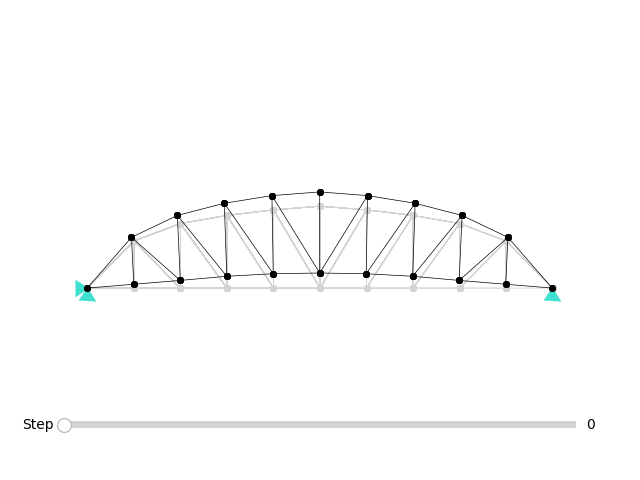

MASS: 360.07710670521664 kg  Natural Frequencies:[20.06682059 40.53905183 61.8225322 ] Hz


In [81]:
# ----------------------------- KANARACHOS TRUSS ---------------------------- #
%matplotlib widget

path_pro = os.path.normpath(os.path.join(read_file_path, 'bridge_frequency_kr.pro'))
props = pu.parse_file(path_pro)

path_geom = os.path.normpath(os.path.join(read_file_path, 'bridge_kanarachos.geom'))
props['model']['truss']['area'] = [ 40e-4, 3.1997e-4, 1.0025e-4, 1.0000e-4, 2.5875e-4, 1.0895e-4, 1.1261e-4, 2.5624e-4, 1.4121e-4, 1.5758e-4, 2.2461e-4, 1.0694e-4, 1.3193e-4, 2.3846e-4, 1.0001e-4 ]
props['init']['mesh']['file'] = path_geom

trap = io.StringIO()
with redirect_stdout(trap):
    globdat = main.jive(props)
# ------------------------ Initiate a Karnachos obect ------------------------ #
read_file_path = '../truss_bridge/data'
read_file = 'bridge_kanarachos.geom'
write_file_path =  None
write_file = None
violation_factor = None
freq_constraints = None
mass_weight = None
freq_weight = None
scalers = [None,None]
bounds = None

TRUSSKN= TRUSS(read_file_path,
               read_file,
                write_file_path,
                write_file,
                violation_factor,
                scalers,
                bounds,
                freq_constraints= freq_constraints, 
                mass_weight= mass_weight, 
                freq_weight= freq_weight)
TRUSSKN.read_geom_file()

y_coord = TRUSSKN.state["y_coordinates"][::2][1:6]
areas_kn = np.array(props['model']['truss']['area'])
print(f'MASS: {TRUSSKN.mass_truss(areas_kn, y_coord)} kg  Natural Frequencies:{(globdat[gn.EIGENFREQS][0:3] / 2 / np.pi)} Hz')

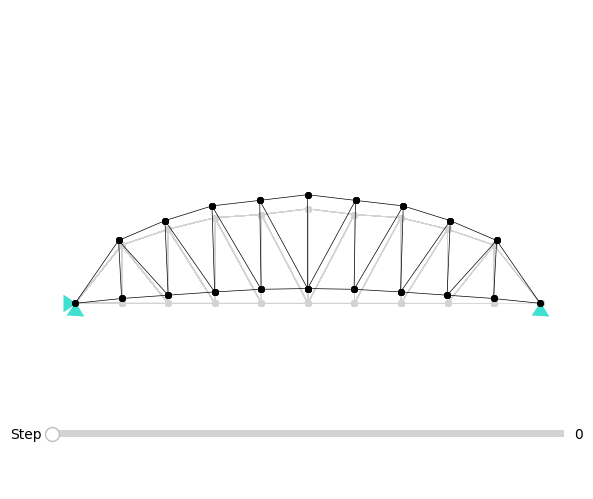

In [21]:
# ---------------------------------- TRUSS1 ---------------------------------- #
TRUSSDummy.Write_call_state(X_init_single)

### <strong> 4.2 | Comparing benchmarks </strong>

In [69]:
mask = TRUSS1.state["monitor_df"]["Natural Frequencies"][:].apply(lambda x: (x >= TRUSS1.config["freq_constraints"]).all())
ind = TRUSS1.state["monitor_df"][mask]["Mass of Truss"].idxmin()
# ----------------------------------- Data ----------------------------------- #
TR_cs = TRUSS1.state["cross_sections"].numpy()
KN_cs = TRUSSKN.state["cross_sections"]

TR_m = TRUSS1.mass_truss(TR_cs, TRUSS1.state["y_coordinates"][::2][1:6])
KN_m = TRUSSKN.mass_truss(KN_cs, TRUSSKN.state["y_coordinates"][::2][1:6])

NFK = globdat[gn.EIGENFREQS][0:3]/2/np.pi
NFTR = TRUSS1.state["monitor_df"]["Natural Frequencies"][ind]

data = {
    'Model': ['Kanarachos model', 'TRUSS model'],
    'Cross Section Average': [KN_cs.mean(), TR_cs.mean()],
    'Natural Frequency Average': [np.mean(NFTR), np.mean(NFK)],
    'Mass': [KN_m, TR_m]
}
basic_comp = pd.DataFrame(data)
basic_comp.set_index('Model', inplace=True)
basic_comp.index.name = None
basic_comp

,Cross Section Average,Natural Frequency Average,Mass
Kanarachos model,0.000424,41.572427,360.077107
TRUSS model,0.000433,40.809468,364.825316


In [75]:
max_cross_sections = max(np.max(TR_cs), np.max(KN_cs))
normalized_cross_sections_model1 = TR_cs / max_cross_sections
normalized_cross_sections_model2 = KN_cs / max_cross_sections

max_mass = max(TR_m, KN_m)
normalized_mass_model1 = TR_m / max_mass
normalized_mass_model2 = KN_m / max_mass

max_nat_freq = max(np.max(NFTR), np.max(NFK))
normalized_nat_freq_model1 = np.array(NFTR) / max_nat_freq
normalized_nat_freq_model2 = np.array(NFK) / max_nat_freq
# ------------------------------------ VIS ----------------------------------- #
# Data for plotting
data = {
    "Metric": ["Cross Sections (Mean)", "Mass", "Nat. Freq. 1", "Nat. Freq. 2", "Nat. Freq. 3"],
    "Model 1 (TRUSS1)": [np.mean(normalized_cross_sections_model1), normalized_mass_model1] + normalized_nat_freq_model1.tolist(),
    "Model 2 (KANARACHOS)": [np.mean(normalized_cross_sections_model2), normalized_mass_model2] + normalized_nat_freq_model2.tolist()
}
df = pd.DataFrame(data)

In [76]:
fig = go.Figure()
colors = ['#00B8C8', '#009bc2']  

for i, model in enumerate(df.columns[1:]):
    fig.add_trace(go.Bar(
        x=df['Metric'],
        y=df[model],
        name=model,
        marker=dict(color=colors[i])
    ))

fig.update_layout(
    title="Comparison of Normalized Cross Sections, Mass, and Natural Frequencies",
    xaxis=dict(
        title="Metric",
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        zerolinecolor='rgba(150, 150, 150, 0.8)',  
    ),
    yaxis=dict(
        title="Normalized Value",
        showgrid=True,
        gridcolor='rgba(211, 211, 211, 0.8)',  
        linecolor='rgba(150, 150, 150, 0.8)',  
        zerolinecolor='rgba(150, 150, 150, 0.8)',  
    ),
    plot_bgcolor='white',
    barmode='group',
    legend_title_text='Model',
    legend_font_size=12,
    margin=dict(l=100, r=100, t=100, b=100),  
)

fig.show()